## 96 well raw data growth experiment analysis


In [1]:
# import block
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import re
from matplotlib_venn import venn3
import math
import sys
import multiprocessing as mp
from time import time, sleep
import openpyxl
import statistics
from scipy.stats import gompertz
from datetime import timedelta, datetime
import numpy as np
plt.rcParams['svg.fonttype'] = 'none'

Raw data file parsing and virtual plate layout creation

In [2]:
''' We have a couple of different instrument so first I need to understand the file layout coming from each one
From a quick checkup it looks like the files are streaming out from the same software - Gen5 so int heory they should look the same unless the export promts are different.'''

# read file to count the lines to skip and lines to read. Also try to identify the column rang automatically

# read into a preprocess df
# store file names in a variable for easy use downstream
filename='synergyh1_2.xlsx'
ppdf=pd.read_excel(filename)
cols=ppdf.columns
#print(cols[0])
# get the plate id, this will be the connector identifier between the plate and plate sample annotation files
plateidobj=ppdf[ppdf[cols[0]]=='Plate Number']
plateid=plateidobj.iloc[0,1]
print('Plate ID is: '+plateid)
# Get the line number of the 315,415 string
# start line number
sln=ppdf.index[ppdf[cols[0]]==315415]
#print(sln[0])
# get the end line number
eln=ppdf.index[ppdf[cols[0]]=='Results']
#print(eln[0])
nr=(eln[0]-sln[0])-4
#print(nr)
# starting from the synergy H1 format
expdf=pd.read_excel(filename, skiprows=sln[0]+3, nrows=nr, usecols="B:CU")
#platedf.to_csv('test_input.csv')
expdf

Plate ID is: Plate 1


,Time,"T° 315,415",A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,00:00:00,23.0,179373,182665,177223,789,805,775,905,784,...,853,825,834,862,918,795,770,837,840,873
1,00:01:10,23.0,209379,203760,200402,766,851,825,843,838,...,867,885,807,855,807,831,759,852,784,866
2,00:02:20,23.0,240475,230881,226856,766,807,801,855,817,...,856,802,858,841,858,833,807,823,767,800
3,00:03:30,23.0,270592,258045,258681,750,827,812,833,752,...,852,828,794,840,851,823,783,860,789,755
4,00:04:40,23.0,297842,285681,282977,837,854,803,846,783,...,854,849,799,818,892,834,828,862,792,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,02:55:00,25.1,1206378,1200328,1203306,745,796,846,817,774,...,813,820,800,825,811,755,781,855,761,768
151,02:56:10,25.1,1209057,1197400,1199231,743,760,798,781,750,...,838,811,790,798,791,749,736,806,766,750
152,02:57:20,25.1,1203533,1200414,1198821,682,836,796,809,767,...,836,772,838,848,817,785,705,767,749,786
153,02:58:30,25.1,1201578,1194486,1203895,803,779,862,768,764,...,847,824,787,800,859,826,809,762,771,758


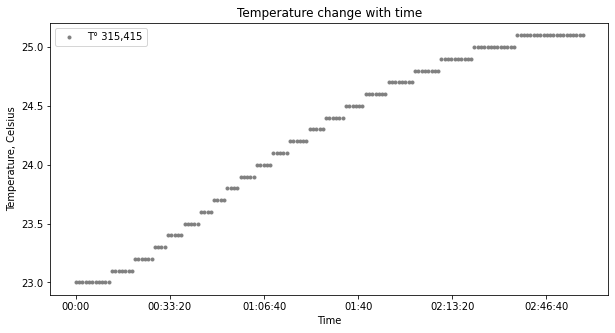

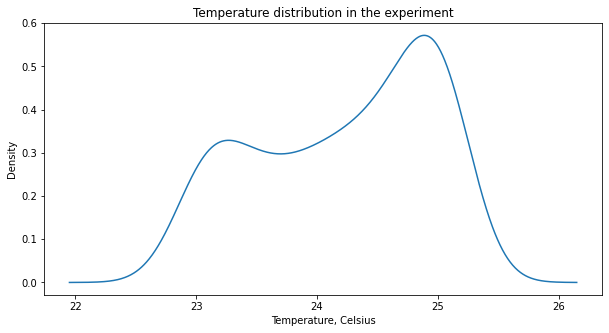

In [3]:
# general plots
# temperature distribution across time
cnames=expdf.columns

expdf.plot(x=cnames[0], y=cnames[1], figsize=(10,5), color='grey',style=".")
plt.title('Temperature change with time')
plt.ylabel('Temperature, Celsius')
plt.savefig('./graphics/tempvstime.svg')
plt.show()

plt.figure()
expdf[cnames[1]].plot.kde(figsize=(10,5), title='Temperature distribution in the experiment')
plt.xlabel('Temperature, Celsius')
plt.savefig('./graphics/temp_dist.svg')
plt.show()



After reading the plate, identify samples by loading a sample file

In [3]:
# get the layout and start calculating metrics
platelayout=pd.read_table('synergyh1_2_layout.txt')
platelayout=platelayout.set_index('sample')

# this will have the output table
workdf=pd.DataFrame()
samples={}
# for each sample, get the average and std values
for sample in platelayout.index:
    triplicates=(platelayout.at[sample,'wells']).split(',')
    triplicates=[s.strip() for s in triplicates]
    # put it in a dictionary
    samples[sample]=triplicates
    
wd={}
# analyze plate
for i,tp in tqdm(expdf.iterrows()):
    wd[tp['Time']]={}
    # calculate the average  and standard deviation per sample
    for sample in samples:
        vals=[]
        for well in samples[sample]:
            # get the values
            vals.append(tp[well])
        # calculate the average and standard deviation:
        sample_avg=statistics.mean(vals)
        sample_std=statistics.stdev(vals)
        
        avg_name=sample+'_avg_bc'
        stdev_name=sample+'_stdev_bc'
        wd[tp['Time']][avg_name]=sample_avg
        wd[tp['Time']][stdev_name]=sample_std
        
workdf=pd.DataFrame.from_dict(wd, orient='index')
workdf
        
    

155it [00:00, 8554.85it/s]


,1U_avg_bc,1U_stdev_bc,5U_avg_bc,5U_stdev_bc,10U_avg_bc,10U_stdev_bc,NC_avg_bc,NC_stdev_bc
00:00:00,1.797537e+05,2740.897906,5.287937e+05,11732.808459,5.794353e+05,14163.039022,814.000000,34.641016
00:01:10,2.045137e+05,4535.707479,6.539010e+05,12652.048332,7.335930e+05,15618.206907,819.666667,14.047538
00:02:20,2.327373e+05,6996.697102,7.459667e+05,10559.778517,8.330230e+05,12995.603911,808.333333,21.455380
00:03:30,2.624393e+05,7067.574148,8.166773e+05,15449.231739,8.893393e+05,4642.590261,808.333333,27.227437
00:04:40,2.888333e+05,7918.014924,8.840830e+05,19411.708915,9.531530e+05,30619.070642,790.333333,37.220066
...,...,...,...,...,...,...,...,...
02:55:00,1.203337e+06,3025.121706,1.295670e+06,16563.351241,1.172090e+06,11840.703625,763.000000,19.974984
02:56:10,1.201896e+06,6268.818150,1.298392e+06,20553.403838,1.175906e+06,10778.731481,775.000000,44.226689
02:57:20,1.200923e+06,2396.829642,1.295645e+06,14939.038836,1.174149e+06,8456.168695,794.000000,38.431758
02:58:30,1.199986e+06,4902.282360,1.295572e+06,19773.140224,1.176018e+06,7208.857353,807.666667,34.530180


We have the raw averages and standaed deviations now we can plot the basic growth curves

In [4]:
# first, subtract the controls from the sample columns
# mark the blank
blank='NC'
graphdf=pd.DataFrame()
sample_names=[]
err_names=[]
for sample in samples:
    if 'NC' in sample:
        continue
    colname=sample+'_avg_bc'
    std_cname=sample+'_stdev_bc'
    new_sample_name=sample+'_avg'
    testdiff=workdf[colname]-workdf['NC_avg_bc']
    cdiff=pd.Series(testdiff, name=new_sample_name)
    
    graphdf=pd.concat([graphdf,cdiff],axis=1)
    # attach the stdev column
    graphdf=pd.concat([graphdf,workdf[[std_cname]]],axis=1)
    sample_names.append(new_sample_name)
    err_names.append(std_cname)
graphdf.index=graphdf.index.set_names(['Time'])
graphdf.reset_index(inplace=True)


# add a minutes column for easy plotting and calculations
minuteslist=[]
for t in graphdf['Time']:
    t0=graphdf.loc[0]['Time']
    hrs=t.hour
    minutes=t.minute
    seconds=t.second
    # calculate minutes
    tminutes=(hrs*60)+minutes+seconds/60
    minuteslist.append(tminutes)
    
# add the column to grapdf
minuteseries=pd.Series(minuteslist, name='total_minutes')
graphdf=pd.concat([graphdf,minuteseries],axis=1)
graphdf


,Time,1U_avg,1U_stdev_bc,5U_avg,5U_stdev_bc,10U_avg,10U_stdev_bc,total_minutes
0,00:00:00,1.789397e+05,2740.897906,5.279797e+05,11732.808459,5.786213e+05,14163.039022,0.000000
1,00:01:10,2.036940e+05,4535.707479,6.530813e+05,12652.048332,7.327733e+05,15618.206907,1.166667
2,00:02:20,2.319290e+05,6996.697102,7.451583e+05,10559.778517,8.322147e+05,12995.603911,2.333333
3,00:03:30,2.616310e+05,7067.574148,8.158690e+05,15449.231739,8.885310e+05,4642.590261,3.500000
4,00:04:40,2.880430e+05,7918.014924,8.832927e+05,19411.708915,9.523627e+05,30619.070642,4.666667
...,...,...,...,...,...,...,...,...
150,02:55:00,1.202574e+06,3025.121706,1.294907e+06,16563.351241,1.171327e+06,11840.703625,175.000000
151,02:56:10,1.201121e+06,6268.818150,1.297617e+06,20553.403838,1.175131e+06,10778.731481,176.166667
152,02:57:20,1.200129e+06,2396.829642,1.294851e+06,14939.038836,1.173355e+06,8456.168695,177.333333
153,02:58:30,1.199179e+06,4902.282360,1.294765e+06,19773.140224,1.175210e+06,7208.857353,178.500000


Plotting the growth curves

C:\Users\Shany Ofaim\AppData\Local\Temp\ipykernel_10112\548495325.py:35: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  max_val=list(graphdf.loc[max_diff_idx][sample])
C:\Users\Shany Ofaim\AppData\Local\Temp\ipykernel_10112\548495325.py:35: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  max_val=list(graphdf.loc[max_diff_idx][sample])
C:\Users\Shany Ofaim\AppData\Local\Temp\ipykernel_10112\548495325.py:35: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  max_val=list(graphdf.loc[max_diff_idx][sample])


<Figure size 432x288 with 0 Axes>

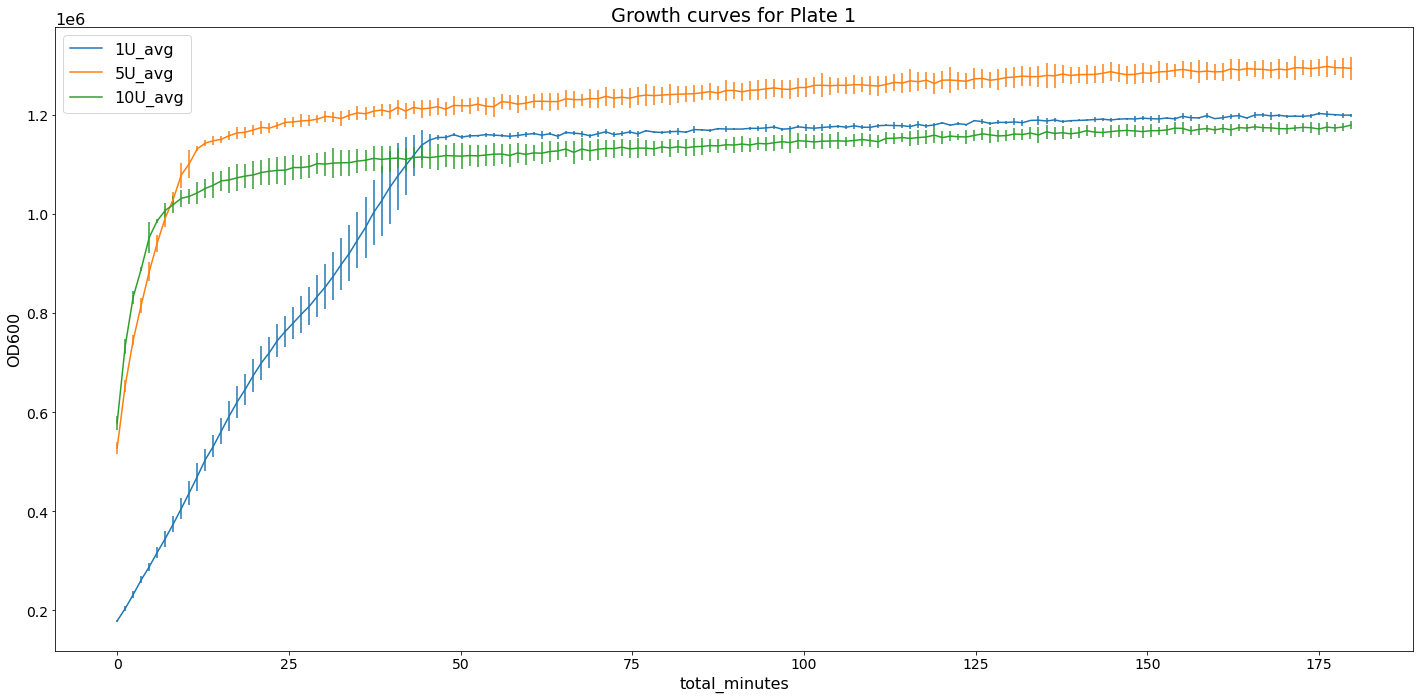

In [38]:
def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    return m


plt.figure()
plt.rcParams.update({'font.size': 16}) 
graphdf.plot(x='total_minutes', y=sample_names,yerr=graphdf[err_names].T.values, 
             figsize=(20,10),
             ylabel='OD600',
             title='Growth curves for '+plateid,
             #logy=True,
             fontsize=14)
colors=['red','blue','grey','blue']
# plot in the mid-log phases
for i,sample in enumerate(sample_names):
    if 'NC' in sample:
        continue
    lst=graphdf[sample].values
    mlst=graphdf['total_minutes'].values
    # get the slopes between each pair of points
    slopes=[]
    for n,point in enumerate(lst):
        if n==len(lst)-1:
            continue
        x1=lst[n]
        y1=mlst[n]
        x2=lst[n+1]
        y2=mlst[n+1]
        s=slope(x1,y1,x2,y2)
        slopes.append(s)
    # where is the maximum difference between two points
    max_item = max(slopes)
    max_diff_idx= {slopes.index(max_item)}
    max_val=list(graphdf.loc[max_diff_idx][sample])
    #plt.axhline(y=max_val[0], color=colors[i], linestyle='-')   
    '''max_slope=np.argmax(np.gradient(lst))
    max_val=graphdf.loc[max_slope][sample]
    max_tts=graphdf.loc[max_slope]['Time']
    plt.axhline(y=max_val, color=colors[i], linestyle='-')
    plt.axvline(x=max_tts,color=colors[i], linestyle='-')'''

plt.tight_layout()
plt.savefig('./graphics/growth_curves.svg')
plt.show()





Calculating metrics and populating output table

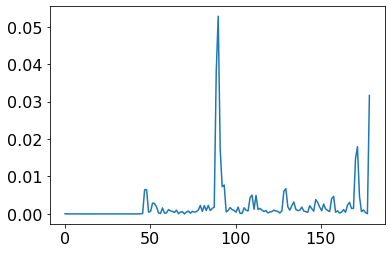

77


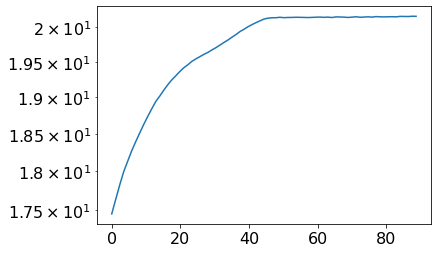

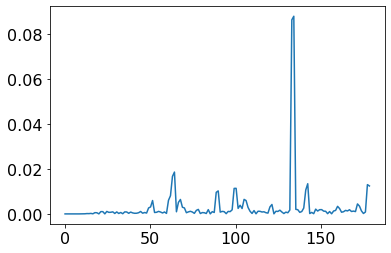

115


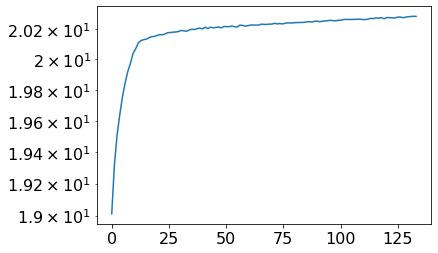

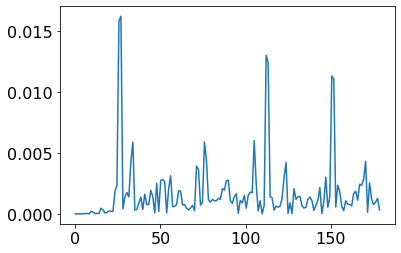

23


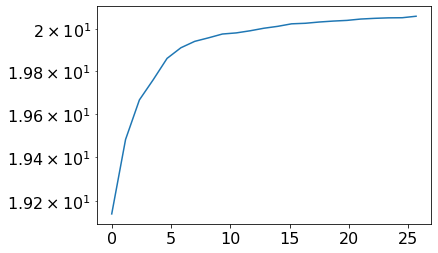

In [36]:
# get the metrics and populate the output table

outputdf=pd.DataFrame()

for sample in sample_names:
    ogsample=sample.replace('_avg','')
    # get mid-log phase
    lst=graphdf[sample].values
    max_slope=np.argmax(np.gradient(lst))
    max_val=graphdf.loc[max_slope][sample]
    max_tts=graphdf.loc[max_slope]['Time']
    
    # calculate growth_rate
    # get the exponential section of the graph
    lst=graphdf[sample].values
    mlst=graphdf['total_minutes'].values
    # get the slopes between each pair of points
    slopes=[]
    oldslope=0
    for n,point in enumerate(lst):
        if n==len(lst)-1:
            continue
        x1=lst[n]
        y1=mlst[n]
        x2=lst[n+1]
        y2=mlst[n+1]
        s=slope(x1,y1,x2,y2)
        slopediff=oldslope-s
        slopes.append(np.abs(slopediff))
        oldslope=s
    plt.figure()
    sns.lineplot(x=mlst[0:154],y=slopes)
    plt.show()
    # where is the maximum difference between two points
    max_item = max(slopes)
    max_diff_idx= slopes.index(max_item)
    print(max_diff_idx)
    grlist=lst[0:max_diff_idx]
    grtimes=mlst[0:max_diff_idx]
    # convert the data to log2
    log2vals=list(np.log2(grlist))
    # plot vs. Time
    plt.figure()
    g=sns.lineplot(x=grtimes,y=log2vals)
    g.set(yscale='log')
    plt.show()
    # add info to the output table
    values_to_add = { 'sample_name':ogsample,'wells': samples[ogsample],'max_OD':graphdf[sample].max(),'growth_rate':10,'ttr_maxOD':graphdf.loc[graphdf[[sample]].idxmax()]['Time'],'mid_log':max_val,'ttr_mid_log':max_tts, 'plate_id':plateid}
    row_to_add = pd.Series(values_to_add, name=tp['Time'])
    new_df=pd.DataFrame([row_to_add], columns=row_to_add._stat_axis)
    workdf = pd.concat([workdf,new_df],ignore_index=True)